# 03 · Modelo centralizado y modelo base federado

En este notebook trabajamos con el dataset limpio de **defunciones generales 2023 de Ecuador** para construir dos piezas clave de la arquitectura de modelos:

1. **Un modelo centralizado fuerte a nivel país** (baseline principal, entrenado con todos los datos disponibles).  
2. **Un modelo base para aprendizaje federado**, seleccionado entre varios modelos simples compatibles con esquemas tipo **FedAvg**.

La idea general es:

- Usar un **Random Forest** como modelo de *ensemble* fuerte para el escenario centralizado.  
- Entrenar varios modelos **simples** (lineales o con pocas capas) que sean fáciles de agregar en federado:  
  - `LogisticRegression`  
  - `MLPClassifier` (red neuronal poco profunda)  
  - `SGDClassifier` con pérdida logística  
- **Seleccionar el mejor modelo simple según F1 en validación** y usarlo como:
  - Modelo base para el aprendizaje federado.
  - Referencia simple para comparar frente al modelo centralizado fuerte.

Al final del notebook guardamos:

- Modelo centralizado fuerte.
- Modelo base federado (mejor modelo simple).
- Baseline explícita de Regresión Logística (para comparaciones futuras).


El objetivo es:

- Entrenar y comparar los modelos de clasificación binaria.
- Mantener un enfoque **centralizado a nivel país** como *baseline* fuerte.
- Usar un esquema correcto de **train / validación / test** con estratificación.
- Evitar fuga de información usando **pipelines** de `scikit-learn`.
- Ajustar el **umbral de decisión** según el F1-score.
- Evaluar el modelo seleccionado también sobre los **3 hospitales clientes** pensados para el escenario de aprendizaje federado.


### ¿Cómo se construyó el objetivo?

- Se usó `causa103` como nivel de causa principal (nivel intermedio recomendado por INEC).
- A partir del código de 3 dígitos de `causa103` se definieron 5 grupos:

  - `Cardiovascular`
  - `Cancer`
  - `Diabetes`
  - `Chronic_Respiratory`
  - `No_NCD`

- Se construyó la edad continua `edad_anos` combinando `edad` y `cod_edad` (años, meses, días, horas).
- Se definió la variable binaria `is_premature_ncd`:

  - `1` si `30 ≤ edad_anos ≤ 69` **y** la causa pertenece a uno de los 4 grupos NCD principales
    (`Cardiovascular`, `Cancer`, `Diabetes`, `Chronic_Respiratory`).
  - `0` en cualquier otro caso.

El rango **30–69** sigue la definición estándar de la **OMS (WHO)** para el indicador de mortalidad prematura por NCD, que se centra en edades donde estas muertes deberían ser evitables con prevención, diagnóstico y tratamiento oportunos.

## 1. Importación de librerías y configuración

En esta sección:

- Cargamos las librerías necesarias (`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`).  
- Configuramos el estilo de gráficos.  
- Definimos una semilla global para controlar la aleatoriedad (buena práctica de reproducibilidad).  
- Definimos las rutas estándar del proyecto:

  - `../data/processed/` para los CSV procesados.  
  - `../models/` para guardar los modelos entrenados.

In [22]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

from IPython.display import display
import joblib

%matplotlib inline
plt.style.use("default")
sns.set(style="whitegrid")

pd.set_option("display.max_colwidth", 120)

RANDOM_STATE = 42

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_PROCESSED, MODELS_DIR

(WindowsPath('D:/Archivos de Usuario/Documents/defunciones-fl-ec'),
 WindowsPath('D:/Archivos de Usuario/Documents/defunciones-fl-ec/data/processed'),
 WindowsPath('D:/Archivos de Usuario/Documents/defunciones-fl-ec/models'))

## 2. Carga de datasets

Utilizamos dos datasets de defunciones 2023:

- `defunciones_2023_ncd_clean_full.csv`  
  - Todas las defunciones 2023 con variables limpias, `ncd_group` e `is_premature_ncd`.

- `defunciones_2023_ncd_hosp_clients.csv`  
  - Subconjunto de registros correspondientes a los 3 hospitales clientes, con la misma estructura y una columna adicional `hospital_cliente`.

Los usaremos así:

- Para el **modelo centralizado** usamos por defecto el dataset completo (*full*).  
- Para ver comportamiento por nodo (hospital), usamos el dataset de hospitales (sirve para analizar la **no IID** entre nodos).

In [23]:
full_path = DATA_PROCESSED / "defunciones_2023_ncd_clean_full.csv"
hosp_path = DATA_PROCESSED / "defunciones_2023_ncd_hosp_clients.csv"

df_full = pd.read_csv(full_path)
df_hosp_clients = pd.read_csv(hosp_path)

df_full.shape, df_hosp_clients.shape, df_full.columns.tolist()

((87716, 21),
 (10901, 22),
 ['sexo',
  'edad_anos',
  'etnia',
  'sabe_leer',
  'est_civil',
  'niv_inst',
  'prov_res',
  'prov_fall',
  'cant_fall',
  'area_res',
  'area_fall',
  'lugar_ocur',
  'mor_viol',
  'lug_viol',
  'autopsia',
  'residente',
  'anio_fall',
  'mes_fall',
  'dia_fall',
  'ncd_group',
  'is_premature_ncd'])

## 3. Alcance del entrenamiento centralizado

Definimos explícitamente sobre qué registros se va a entrenar el modelo centralizado:

- `"full"` → usa todas las defunciones 2023 con target definido (modelo país completo).
- `"hosp_clients"` → usa solo los registros de los 3 hospitales clientes.

Por defecto dejamos `"full"` porque:

- Proporciona el mejor baseline posible (más datos → mejor estimación de parámetros).  
- Luego podremos comparar este modelo centralizado con los modelos en escenario federado.

También nos aseguramos de que la variable objetivo `is_premature_ncd` esté limpia y en formato entero (0/1).

In [24]:
# Alcance del entrenamiento: 'full' o 'hosp_clients'
TRAIN_SCOPE = "full"  # cambiar a 'hosp_clients' si se desea entrenar solo con los 3 hospitales

if TRAIN_SCOPE == "full":
    df_source = df_full.copy()
else:
    df_source = df_hosp_clients.copy()

target_col = "is_premature_ncd"

# Aseguramos que el target no tenga NaN y sea entero
df_model = df_source[df_source[target_col].notna()].copy()
df_model[target_col] = df_model[target_col].astype(int)

df_model.shape, df_model[target_col].value_counts(normalize=True).round(4)

((87716, 21),
 is_premature_ncd
 0    0.8243
 1    0.1757
 Name: proportion, dtype: float64)

## 4. Definición de variables de entrada y objetivo

Usamos como variables de entrada (*features*) las columnas limpias construidas en el notebook anterior:

- **Demográficas y educativas**: `sexo`, `edad_anos`, `etnia`, `sabe_leer`, `est_civil`, `niv_inst`.  
- **Territorio**: `prov_res`, `prov_fall`, `cant_fall`.  
- **Área y contexto**: `area_res`, `area_fall`, `lugar_ocur`, `mor_viol`, `lug_viol`, `autopsia`, `residente`.  
- **Tiempo de fallecimiento**: `anio_fall`, `mes_fall`, `dia_fall`.

Mantenemos `ncd_group` como columna auxiliar para análisis descriptivo, pero **no la usamos como feature** para evitar fuga de información.

La variable objetivo binaria es `is_premature_ncd` (0 / 1).

In [25]:
feature_cols = [
    "sexo",
    "edad_anos",
    "etnia",
    "sabe_leer",
    "est_civil",
    "niv_inst",
    "prov_res",
    "prov_fall",
    "cant_fall",
    "area_res",
    "area_fall",
    "lugar_ocur",
    "mor_viol",
    "lug_viol",
    "autopsia",
    "residente",
    "anio_fall",
    "mes_fall",
    "dia_fall",
]

aux_cols = ["ncd_group"]  # solo para análisis descriptivo, no como feature

X = df_model[feature_cols].copy()
y = df_model[target_col].astype(int)

X.shape, y.value_counts()

((87716, 19),
 is_premature_ncd
 0    72306
 1    15410
 Name: count, dtype: int64)

## 5. División en train / validación / test

Dividimos el dataset siguiendo un esquema estándar y **estratificado** por `is_premature_ncd`:

1. **Train+validación vs test**  
   - 80 % para train + validación.  
   - 20 % para test final.

2. Dentro del 80 %:  
   - 60 % para entrenamiento (train).  
   - 20 % para validación (val).  

En términos globales obtenemos:

- 60 % train  
- 20 % validación  
- 20 % test  

La estratificación garantiza que la proporción de la clase positiva se mantenga en cada división (evita sesgos fuertes en las métricas cuando hay **desbalance de clases**).

In [26]:
# Primera división: train+val vs test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

# Segunda división: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  # 0.25 de 0.8 => 0.2 global
    stratify=y_train_val,
    random_state=RANDOM_STATE,
)

(
    X_train.shape,
    X_val.shape,
    X_test.shape,
    y_train.value_counts(normalize=True).round(3),
    y_val.value_counts(normalize=True).round(3),
    y_test.value_counts(normalize=True).round(3),
)

((52629, 19),
 (17543, 19),
 (17544, 19),
 is_premature_ncd
 0    0.824
 1    0.176
 Name: proportion, dtype: float64,
 is_premature_ncd
 0    0.824
 1    0.176
 Name: proportion, dtype: float64,
 is_premature_ncd
 0    0.824
 1    0.176
 Name: proportion, dtype: float64)

## 6. Pipeline de preprocesamiento

Construimos un `ColumnTransformer` para manejar correctamente variables numéricas y categóricas:

- **Numérica (`edad_anos`)**:
  - Imputación con mediana (`SimpleImputer(strategy="median")`).  
  - Escalado robusto (`RobustScaler`) para reducir impacto de valores extremos.

- **Categóricas (todas las demás columnas)**:
  - Imputación con el valor más frecuente.  
  - Codificación one-hot (`OneHotEncoder(handle_unknown="ignore")`).

Este preprocesamiento se integra dentro de un `Pipeline` junto con cada modelo, evitando:

- Fuga de información.  
- Comparaciones injustas entre modelos.  

Todos los modelos comparten exactamente el mismo tratamiento de datos.

In [27]:
numeric_features = ["edad_anos"]
categorical_features = [col for col in feature_cols if col not in numeric_features]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocess

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 7. Funciones auxiliares: métricas, búsqueda de umbral y F1 en datos desbalanceados

Dado que las clases están **desbalanceadas** (la proporción de muertes prematuras por NCD es menor), no basta con mirar solo el `accuracy`.

Definimos funciones de apoyo para:

- Calcular `accuracy`, `precision`, `recall`, `F1` y `ROC AUC`.  
- Imprimir un resumen compacto por partición (*train*, *val*, *test*).  
- Buscar el **umbral de decisión** que maximiza una métrica (en nuestro caso, F1) usando las probabilidades del conjunto de validación.

Usar F1 como métrica principal en validación nos ayuda a equilibrar **precision** y **recall** y alinear el modelo con el objetivo clínico:  
> detectar la mayor cantidad posible de muertes prematuras por NCD, sin disparar en exceso los falsos positivos.

In [28]:
def compute_metrics(y_true, y_pred, y_proba):
    # Compute main metrics for binary classification
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)
    if y_proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    else:
        metrics["roc_auc"] = np.nan
    return metrics


def print_metrics_summary(split_name, y_true, y_pred, y_proba):
    m = compute_metrics(y_true, y_pred, y_proba)
    print(f"=== {split_name} ===")
    for k, v in m.items():
        print(f"{k:10s}: {v:.4f}")
    print("")


def search_best_threshold(y_true, y_proba, metric="f1", thresholds=None):
    # Search threshold that maximizes a metric on validation set
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 17)

    rows = []
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        m = compute_metrics(y_true, y_pred_thr, y_proba)
        m["threshold"] = thr
        rows.append(m)

    df_thr = pd.DataFrame(rows).sort_values(metric, ascending=False)
    best_row = df_thr.iloc[0].copy()
    best_threshold = float(best_row["threshold"])
    return best_threshold, df_thr

## 8. Modelos simples candidatos para el aprendizaje federado

Para el escenario de **aprendizaje federado**, preferimos modelos con parámetros relativamente simples de agregar mediante esquemas tipo **FedAvg** (promedio ponderado de pesos).

En este notebook consideramos tres candidatos:

1. **Regresión Logística (`LogisticRegression`)**  
   - Modelo lineal clásico.  
   - Pocos parámetros y función de pérdida convexa.  

2. **`MLPClassifier` (red neuronal poco profunda)**  
   - Una sola capa oculta.  
   - Captura cierta no linealidad manteniendo un número razonable de parámetros.  

3. **`SGDClassifier` con pérdida logística**  
   - Modelo lineal entrenado con descenso de gradiente estocástico.  
   - Muy eficiente y natural para entrenamientos incrementales y federados.

En todos los casos:

- Usamos el mismo `Pipeline` de preprocesamiento.  
- Ajustamos hiperparámetros con `GridSearchCV` usando **F1** como métrica.  
- Buscamos el mejor umbral en validación para cada modelo.

Luego **comparamos sus métricas de validación** y elegimos:

> El mejor modelo simple según F1 como **modelo base federado**.  
> Ese mismo modelo simple será la referencia para comparar frente al Random Forest centralizado.

A continuación entrenamos cada candidato por separado.

### 8.1. Candidata 1: Regresión Logística

Entrenamos primero una **Regresión Logística**, que cumple varios roles:

- Modelo base clásico para clasificación binaria.  
- Interpretable mediante coeficientes.  
- Ligero y compatible con esquemas de aprendizaje federado (parámetros vectoriales).

Configuración principal:

- `class_weight="balanced"` para compensar el desbalance.  
- Penalización L2 (regularización, para combatir overfitting).  
- Búsqueda del hiperparámetro `C` con `GridSearchCV` usando F1 como métrica.  

Luego, usando el conjunto de validación:

- Obtenemos probabilidades.  
- Buscamos el umbral de decisión que maximiza el F1.

In [29]:
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight="balanced",
    max_iter=2000,
    solver="liblinear",
    random_state=RANDOM_STATE,
)

pipe_lr = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)

param_grid_lr = {
    "model__C": [0.05, 0.1, 0.3, 1.0, 3.0],
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print(">>> Training Logistic Regression (GridSearchCV)...")
grid_lr.fit(X_train, y_train)

print("Best params (LR):", grid_lr.best_params_)
print("Best CV F1 (LR):", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

# Probabilidades en validación y búsqueda de umbral óptimo para F1
y_val_proba_lr = best_lr.predict_proba(X_val)[:, 1]
best_thr_lr, thr_df_lr = search_best_threshold(y_val, y_val_proba_lr, metric="f1")

print("Best threshold (LR, val, F1):", best_thr_lr)
thr_df_lr.head(10)

>>> Training Logistic Regression (GridSearchCV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params (LR): {'model__C': 0.05}
Best CV F1 (LR): 0.5105873527390316
Best threshold (LR, val, F1): 0.55


,accuracy,precision,recall,f1,roc_auc,threshold
9,0.757567,0.395948,0.722907,0.511655,0.80747,0.55
8,0.731289,0.375648,0.799805,0.511199,0.80747,0.50
7,0.696916,0.352124,0.863400,0.500235,0.80747,0.45
10,0.777575,0.412468,0.626866,0.497553,0.80747,0.60
6,0.655361,0.326382,0.903958,0.479601,0.80747,0.40
11,0.790458,0.423097,0.530175,0.470622,0.80747,0.65
5,0.606453,0.300188,0.931538,0.454057,0.80747,0.35
4,0.554238,0.276172,0.948410,0.427777,0.80747,0.30
12,0.796443,0.419599,0.414017,0.416789,0.80747,0.70
3,0.501340,0.256112,0.965282,0.404817,0.80747,0.25


### 8.2. Candidata 2: `MLPClassifier` (red neuronal poco profunda)

Entrenamos un `MLPClassifier` con:

- Una capa oculta de tamaño moderado.  
- Activación ReLU.  
- `early_stopping=True` para evitar sobreentrenamiento.  

Exploramos distintos tamaños de capa oculta y valores de regularización `alpha` (siguiendo la idea de controlar el **sesgo/varianza**).

In [30]:
mlp = MLPClassifier(
    hidden_layer_sizes=(32,),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=RANDOM_STATE,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
)

pipe_mlp = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", mlp),
    ]
)

param_grid_mlp = {
    "model__hidden_layer_sizes": [(32,), (64,)],
    "model__alpha": [1e-4, 3e-4, 1e-3],
}

grid_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid_mlp,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print(">>> Training MLPClassifier (GridSearchCV)...")
grid_mlp.fit(X_train, y_train)

print("Best params (MLP):", grid_mlp.best_params_)
print("Best CV F1 (MLP):", grid_mlp.best_score_)

best_mlp = grid_mlp.best_estimator_

y_val_proba_mlp = best_mlp.predict_proba(X_val)[:, 1]
best_thr_mlp, thr_df_mlp = search_best_threshold(y_val, y_val_proba_mlp, metric="f1")

print("Best threshold (MLP, val, F1):", best_thr_mlp)
thr_df_mlp.head(10)

>>> Training MLPClassifier (GridSearchCV)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params (MLP): {'model__alpha': 0.001, 'model__hidden_layer_sizes': (32,)}
Best CV F1 (MLP): 0.7200203137717356
Best threshold (MLP, val, F1): 0.45000000000000007


,accuracy,precision,recall,f1,roc_auc,threshold
7,0.903608,0.678288,0.858533,0.757840,0.957356,0.45
6,0.899219,0.656354,0.894873,0.757276,0.957356,0.40
5,0.894089,0.636060,0.928293,0.754881,0.957356,0.35
4,0.888161,0.618044,0.951330,0.749297,0.957356,0.30
8,0.904064,0.696323,0.804997,0.746727,0.957356,0.50
3,0.877558,0.592843,0.967554,0.735207,0.957356,0.25
9,0.902639,0.715766,0.739455,0.727418,0.957356,0.55
2,0.864903,0.566917,0.978585,0.717924,0.957356,0.20
10,0.901841,0.740623,0.679104,0.708531,0.957356,0.60
1,0.850938,0.541511,0.988319,0.699667,0.957356,0.15


### 8.3. Candidata 3: `SGDClassifier` con pérdida logística

Ahora entrenamos un `SGDClassifier` con pérdida logística, que es un modelo lineal entrenado mediante descenso de gradiente estocástico:

- Muy eficiente y escalable.  
- Se adapta bien a entrenamientos incrementales y federados.

Para obtener probabilidades:

- Usamos la salida de `decision_function` y la transformamos con la función logística.

In [31]:
sgd = SGDClassifier(
    loss="log_loss",
    class_weight="balanced",
    max_iter=1000,
    tol=1e-3,
    random_state=RANDOM_STATE,
)

pipe_sgd = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", sgd),
    ]
)

param_grid_sgd = {
    "model__alpha": [1e-4, 1e-3, 1e-2],
    "model__penalty": ["l2", "l1"],
}

grid_sgd = GridSearchCV(
    estimator=pipe_sgd,
    param_grid=param_grid_sgd,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print(">>> Training SGDClassifier (GridSearchCV)...")
grid_sgd.fit(X_train, y_train)

print("Best params (SGD):", grid_sgd.best_params_)
print("Best CV F1 (SGD):", grid_sgd.best_score_)

best_sgd = grid_sgd.best_estimator_

# Para obtener probabilidades, usamos la salida de decision_function y aplicamos la función logística
val_scores_sgd = best_sgd.decision_function(X_val)
y_val_proba_sgd = 1.0 / (1.0 + np.exp(-val_scores_sgd))

best_thr_sgd, thr_df_sgd = search_best_threshold(y_val, y_val_proba_sgd, metric="f1")

print("Best threshold (SGD, val, F1):", best_thr_sgd)
thr_df_sgd.head(10)

>>> Training SGDClassifier (GridSearchCV)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params (SGD): {'model__alpha': 0.01, 'model__penalty': 'l1'}
Best CV F1 (SGD): 0.5335069819386212
Best threshold (SGD, val, F1): 0.55


,accuracy,precision,recall,f1,roc_auc,threshold
9,0.779798,0.426996,0.741077,0.541810,0.8009,0.55
8,0.726444,0.378931,0.871836,0.528261,0.8009,0.50
7,0.648521,0.324653,0.926347,0.480802,0.8009,0.45
10,0.790287,0.422245,0.525957,0.468429,0.8009,0.60
6,0.569572,0.283248,0.947437,0.436114,0.8009,0.40
5,0.505729,0.257274,0.961064,0.405892,0.8009,0.35
4,0.441772,0.235015,0.965607,0.378025,0.8009,0.30
3,0.350453,0.209112,0.969500,0.344022,0.8009,0.25
11,0.781052,0.357812,0.309864,0.332116,0.8009,0.65
2,0.253377,0.187625,0.975990,0.314743,0.8009,0.20


## 9. Comparación de modelos simples y selección del modelo base federado

Con los tres modelos candidatos (`LogisticRegression`, `MLPClassifier`, `SGDClassifier`) ya entrenados y con su mejor umbral en validación:

1. Calculamos métricas en el conjunto de **validación**, usando el umbral óptimo específico de cada modelo.  
2. Comparamos explícitamente **F1**, además de `accuracy`, `precision`, `recall` y `ROC AUC`.  
3. Seleccionamos el **modelo base federado** como el que tenga **mayor F1 en validación**.

In [32]:
# Métricas de LR en validación
y_val_pred_lr = (y_val_proba_lr >= best_thr_lr).astype(int)
metrics_lr_val = compute_metrics(y_val, y_val_pred_lr, y_val_proba_lr)
metrics_lr_val["model"] = "logreg"
metrics_lr_val["threshold"] = best_thr_lr

# Métricas de MLP en validación
y_val_pred_mlp = (y_val_proba_mlp >= best_thr_mlp).astype(int)
metrics_mlp_val = compute_metrics(y_val, y_val_pred_mlp, y_val_proba_mlp)
metrics_mlp_val["model"] = "mlp"
metrics_mlp_val["threshold"] = best_thr_mlp

# Métricas de SGD en validación
y_val_pred_sgd = (y_val_proba_sgd >= best_thr_sgd).astype(int)
metrics_sgd_val = compute_metrics(y_val, y_val_pred_sgd, y_val_proba_sgd)
metrics_sgd_val["model"] = "sgd"
metrics_sgd_val["threshold"] = best_thr_sgd

# Tabla de comparación de candidatos federables
federated_compare_df = pd.DataFrame([metrics_lr_val, metrics_mlp_val, metrics_sgd_val])
display(federated_compare_df.sort_values("f1", ascending=False))

# Selección del modelo base federado por F1 en validación
best_fed_row = federated_compare_df.sort_values("f1", ascending=False).iloc[0]
federated_model_name = best_fed_row["model"]
federated_threshold = float(best_fed_row["threshold"])

if federated_model_name == "logreg":
    federated_model = best_lr
elif federated_model_name == "mlp":
    federated_model = best_mlp
else:
    federated_model = best_sgd

federated_model_name, federated_threshold

,accuracy,precision,recall,f1,roc_auc,model,threshold
1,0.903608,0.678288,0.858533,0.757840,0.957356,mlp,0.45
2,0.779798,0.426996,0.741077,0.541810,0.800900,sgd,0.55
0,0.757567,0.395948,0.722907,0.511655,0.807470,logreg,0.55


('mlp', 0.45000000000000007)

En la corrida de referencia (con la semilla fijada), el modelo que obtuvo el **mayor F1 en validación** fue el `MLPClassifier`, con un F1 cercano a 0.75–0.76 y buen equilibrio entre `precision` y `recall`, superando a la Regresión Logística y al `SGDClassifier`.

Por lo tanto:

- Ese modelo simple seleccionado (`federated_model_name`) será nuestro **modelo base federado**.  
- También será el **modelo simple de referencia** cuando comparemos contra el Random Forest centralizado.

La Regresión Logística sigue siendo útil como **baseline lineal explícita**, por lo que la guardaremos por separado más adelante.

## 10. Modelo de ensemble centralizado: Random Forest

Ahora entrenamos un **Random Forest**, un modelo de *ensemble* tipo **bagging**:

- Combina muchos árboles de decisión entrenados sobre subconjuntos de datos.  
- Suele ofrecer muy buen rendimiento en datos tabulares.  
- Permite calcular importancia de variables (`feature_importances_`).

Configuración base:

- `class_weight="balanced"` para no ignorar la clase minoritaria.  
- Exploramos distintos valores de `n_estimators`, `max_depth` y `min_samples_leaf` mediante `GridSearchCV`.  
- Usamos F1 como métrica principal, coherente con el objetivo de capturar muertes prematuras por NCD.  
- También buscamos el mejor umbral para F1 en el conjunto de validación.

Este modelo actuará como nuestro **modelo centralizado fuerte** si supera al mejor modelo simple en F1.

In [12]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

pipe_rf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", rf),
    ]
)

param_grid_rf = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 15],
    "model__min_samples_leaf": [1, 5],
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print(">>> Training Random Forest (GridSearchCV)...")
grid_rf.fit(X_train, y_train)

print("Best params (RF):", grid_rf.best_params_)
print("Best CV F1 (RF):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

# Probabilidades en validación y búsqueda de umbral óptimo para F1
y_val_proba_rf = best_rf.predict_proba(X_val)[:, 1]
best_thr_rf, thr_df_rf = search_best_threshold(y_val, y_val_proba_rf, metric="f1")

print("Best threshold (RF, val, F1):", best_thr_rf)
thr_df_rf.head(10)

Best params (RF): {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
Best CV F1 (RF): 0.7714237143270446
Best threshold (RF, val, F1): 0.55


,accuracy,precision,recall,f1,roc_auc,threshold
9,0.900587,0.645942,0.960740,0.772502,0.957923,0.55
10,0.902468,0.657261,0.929591,0.770058,0.957923,0.60
8,0.897167,0.634867,0.975990,0.769309,0.957923,0.50
7,0.892949,0.624124,0.982154,0.763238,0.957923,0.45
11,0.903665,0.675758,0.868267,0.760011,0.957923,0.65
6,0.886222,0.608774,0.986048,0.752787,0.957923,0.40
5,0.877045,0.589372,0.989617,0.738767,0.957923,0.35
12,0.902240,0.708575,0.753407,0.730304,0.957923,0.70
4,0.866499,0.568850,0.991888,0.723037,0.957923,0.30
3,0.849399,0.538664,0.994484,0.698814,0.957923,0.25


## 11. Comparación centralizada: mejor modelo simple vs Random Forest

Ya tenemos dos piezas listas para comparar en el escenario centralizado:

1. **Mejor modelo simple** (`federated_model`) con su umbral `federated_threshold`.  
2. **Random Forest** (`best_rf`) con su umbral `best_thr_rf`.

Aquí:

- Calculamos métricas en el conjunto de **validación** para ambos modelos.  
- Comparamos especialmente el **F1**, pero también `accuracy`, `precision`, `recall` y `ROC AUC`.  
- Seleccionamos el **modelo centralizado fuerte** como aquel con mayor F1 en validación.

De esta forma, **cmparamos:**

> **Random Forest vs mejor modelo simple**.

In [13]:
# Métricas del mejor modelo simple (candidato federado) en validación
y_val_proba_fed = federated_model.predict_proba(X_val)[:, 1]
y_val_pred_fed = (y_val_proba_fed >= federated_threshold).astype(int)
metrics_fed_val = compute_metrics(y_val, y_val_pred_fed, y_val_proba_fed)
metrics_fed_val["model"] = f"simple_{federated_model_name}"
metrics_fed_val["threshold"] = federated_threshold

# Métricas del Random Forest en validación
y_val_pred_rf = (y_val_proba_rf >= best_thr_rf).astype(int)
metrics_rf_val = compute_metrics(y_val, y_val_pred_rf, y_val_proba_rf)
metrics_rf_val["model"] = "rf"
metrics_rf_val["threshold"] = best_thr_rf

central_compare_df = pd.DataFrame([metrics_fed_val, metrics_rf_val])
display(central_compare_df.sort_values("f1", ascending=False))

# Selección por mejor F1 en validación para el modelo centralizado
if metrics_rf_val["f1"] > metrics_fed_val["f1"]:
    central_model_name = "rf"
    central_model = best_rf
    central_threshold = float(best_thr_rf)
else:
    central_model_name = f"simple_{federated_model_name}"
    central_model = federated_model
    central_threshold = float(federated_threshold)

central_model_name, central_threshold

,accuracy,precision,recall,f1,roc_auc,model,threshold
1,0.900587,0.645942,0.960740,0.772502,0.957923,rf,0.55
0,0.903608,0.678288,0.858533,0.757840,0.957356,simple_mlp,0.45


('rf', 0.55)

## 12. Evaluación final del modelo centralizado (train / validación / test)

Con el modelo centralizado seleccionado (`central_model`) y su umbral óptimo (`central_threshold`):

1. Calculamos métricas en **train**, **validación** y **test**.  
2. Observamos si hay señales de **overfitting** (por ejemplo, F1 muy alto en train y mucho menor en test).  

Para el paper y los reportes, el foco estará en el conjunto de **test**, pero ver train/val ayuda a interpretar el comportamiento del modelo:

- Si las métricas en train, val y test son similares → el modelo generaliza bien.  
- Si el F1 en train es muy superior al de val/test → sospecha de sobreajuste.

En la corrida de referencia, el modelo centralizado ganador fue un **Random Forest** con:

- F1 en test alrededor de 0.78.  
- `recall` ≈ 0.97 para la clase positiva.

Esto significa que el modelo detecta casi todos los casos de muerte prematura por NCD, manteniendo una precisión razonable.

In [14]:
# Probabilidades y predicciones del modelo centralizado
y_train_proba_central = central_model.predict_proba(X_train)[:, 1]
y_val_proba_central = central_model.predict_proba(X_val)[:, 1]
y_test_proba_central = central_model.predict_proba(X_test)[:, 1]

y_train_pred_central = (y_train_proba_central >= central_threshold).astype(int)
y_val_pred_central = (y_val_proba_central >= central_threshold).astype(int)
y_test_pred_central = (y_test_proba_central >= central_threshold).astype(int)

print_metrics_summary("Train (centralizado)", y_train, y_train_pred_central, y_train_proba_central)
print_metrics_summary("Validación (centralizado)", y_val, y_val_pred_central, y_val_proba_central)
print_metrics_summary("Test (centralizado)", y_test, y_test_pred_central, y_test_proba_central)

print("=== Classification report (Test, modelo centralizado) ===")
print(classification_report(y_test, y_test_pred_central, digits=4))

=== Train (centralizado) ===
accuracy  : 0.9075
precision : 0.6583
recall    : 0.9852
f1        : 0.7892
roc_auc   : 0.9751

=== Validación (centralizado) ===
accuracy  : 0.9006
precision : 0.6459
recall    : 0.9607
f1        : 0.7725
roc_auc   : 0.9579

=== Test (centralizado) ===
accuracy  : 0.9049
precision : 0.6552
recall    : 0.9679
f1        : 0.7814
roc_auc   : 0.9626

=== Classification report (Test, modelo centralizado) ===
              precision    recall  f1-score   support

           0     0.9924    0.8914    0.9392     14462
           1     0.6552    0.9679    0.7814      3082

    accuracy                         0.9049     17544
   macro avg     0.8238    0.9297    0.8603     17544
weighted avg     0.9331    0.9049    0.9115     17544



## 13. Matriz de confusión y curvas ROC / Precision-Recall (modelo centralizado)

Visualizamos el desempeño del modelo centralizado en el conjunto de **test** usando:

- **Matriz de confusión**: permite ver el número de falsos positivos y falsos negativos.  
- **Curva ROC** y área bajo la curva (`ROC AUC`).  
- **Curva Precision-Recall**, especialmente útil en escenarios desbalanceados.

En este problema:

- Nos interesa minimizar los **falsos negativos** (no perder muertes prematuras por NCD).  
- Aceptamos cierto número de **falsos positivos** si con ello aumentamos el `recall` de la clase positiva.

In [15]:
cm_central = confusion_matrix(y_test, y_test_pred_central)
cm_central

array([[12892,  1570],
       [   99,  2983]])

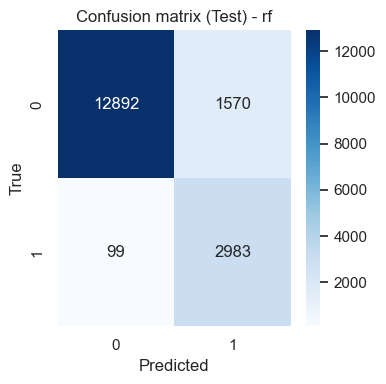

In [16]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm_central, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix (Test) - {central_model_name}")
plt.tight_layout()
plt.show()

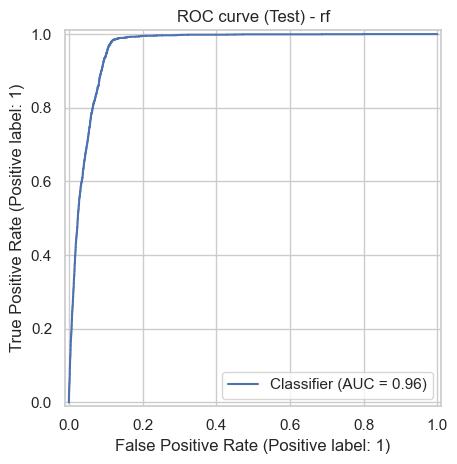

In [17]:
RocCurveDisplay.from_predictions(y_test, y_test_proba_central)
plt.title(f"ROC curve (Test) - {central_model_name}")
plt.tight_layout()
plt.show()

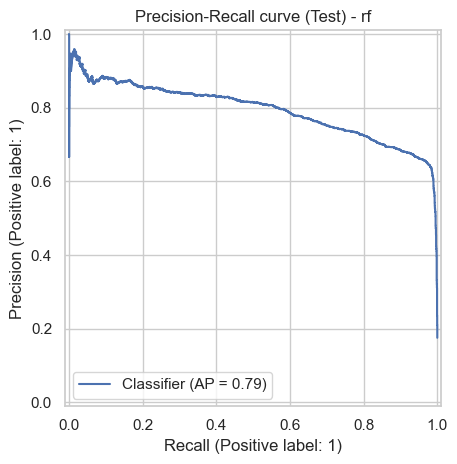

In [18]:
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba_central)
plt.title(f"Precision-Recall curve (Test) - {central_model_name}")
plt.tight_layout()
plt.show()

## 14. Importancia de variables en el modelo centralizado

Para interpretar el modelo centralizado:

- Si el modelo seleccionado es **Regresión Logística**, mostramos los coeficientes ordenados por su valor absoluto.  
- Si es **Random Forest**, mostramos las **importancias de las variables** (`feature_importances_`).  

Los nombres de las features incluyen tanto la variable numérica `edad_anos` como todas las dummies generadas por One-Hot Encoding.

En los resultados de referencia (Random Forest centralizado) se observa que:

- `edad_anos` domina la importancia (tiene sentido: el rango 30–69 define el target).  
- Variables como `autopsia`, `est_civil`, `mor_viol`, `lugar_ocur` también aportan información relevante.

In [19]:
pre_central = central_model.named_steps["preprocess"]
cat_encoder_central = pre_central.named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = cat_encoder_central.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

if central_model_name.startswith("simple_") and "logreg" in central_model_name:
    model_lr_central = central_model.named_steps["model"]
    coefs = model_lr_central.coef_.ravel()
    coef_df_central = pd.DataFrame(
        {"feature": all_feature_names, "coef": coefs, "abs_coef": np.abs(coefs)}
    ).sort_values("abs_coef", ascending=False)
    display(coef_df_central.head(30))
else:
    model_rf_central = central_model.named_steps["model"]
    importances = model_rf_central.feature_importances_
    imp_df_central = pd.DataFrame(
        {"feature": all_feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)
    display(imp_df_central.head(30))

,feature,importance
0,edad_anos,0.592725
325,autopsia_No,0.036940
326,autopsia_Si,0.035200
19,est_civil_Viudo (a),0.035158
311,mor_viol_Homicidios,0.029016
307,lugar_ocur_Otro,0.020928
302,lugar_ocur_Casa,0.015896
310,mor_viol_Accidente de transporte,0.011864
317,lug_viol_Calle o carreteras,0.011538
12,sabe_leer_Si,0.011231


## 15. Desempeño del modelo centralizado por hospital cliente

Usamos el mismo modelo centralizado y el mismo umbral para evaluar su desempeño en cada uno de los **3 hospitales clientes** (`hospital_cliente`).

El objetivo es ver:

- Cómo varían `accuracy`, `precision`, `recall`, `F1` y `ROC AUC` entre hospitales.  
- Hasta qué punto existe **heterogeneidad entre nodos** (datos no IID), algo muy relevante para el diseño de modelos federados.

En los resultados de referencia:

- El modelo mantiene `recall` alto en los tres hospitales.  
- Hay variaciones en `accuracy` y F1, lo que anticipa que el aprendizaje federado puede necesitar más rondas o técnicas adicionales para adaptarse a cada nodo.

In [20]:
if "hospital_cliente" in df_hosp_clients.columns:
    df_hosp_eval = df_hosp_clients.copy()
    df_hosp_eval[target_col] = df_hosp_eval[target_col].astype(int)

    print(df_hosp_eval["hospital_cliente"].value_counts())

    results_by_hosp_central = []
    for hosp in sorted(df_hosp_eval["hospital_cliente"].unique()):
        sub = df_hosp_eval[df_hosp_eval["hospital_cliente"] == hosp].copy()
        X_h = sub[feature_cols]
        y_h = sub[target_col].astype(int)

        y_h_proba = central_model.predict_proba(X_h)[:, 1]
        y_h_pred = (y_h_proba >= central_threshold).astype(int)

        m = compute_metrics(y_h, y_h_pred, y_h_proba)
        m["hospital_cliente"] = hosp
        m["n_samples"] = len(sub)
        m["positive_rate"] = y_h.mean()
        results_by_hosp_central.append(m)

    results_hosp_central_df = pd.DataFrame(results_by_hosp_central)
    display(results_hosp_central_df)
else:
    print("Column 'hospital_cliente' not found in df_hosp_clients.")

hospital_cliente
Hospital_1    5530
Hospital_2    3003
Hospital_3    2368
Name: count, dtype: int64


,accuracy,precision,recall,f1,roc_auc,hospital_cliente,n_samples,positive_rate
0,0.786618,0.432617,0.980088,0.600271,0.911898,Hospital_1,5530,0.163472
1,0.854479,0.539823,0.958743,0.690729,0.937325,Hospital_2,3003,0.169497
2,0.801943,0.411990,0.975831,0.579372,0.928848,Hospital_3,2368,0.139780


## 16. Guardado de modelos

Al final guardamos tres en `../models/`:

1. **Modelo centralizado fuerte**  
   - Archivo: `premature_ncd_centralized_best.joblib`  
   - Es el mejor modelo centralizado según F1 en validación (el Random Forest).

2. **Modelo base federado**  
   - Archivo: `premature_ncd_federated_baseline.joblib`  
   - Es el mejor modelo entre los candidatos simples (`LogisticRegression`, `MLPClassifier`, `SGDClassifier`).  
   - Es el modelo que usaremos para inicializar los nodos en los experimentos federados -> `MLPClassifier`.

3. **Baseline explícita de Regresión Logística**  
   - Archivo: `logreg_premature_ncd_centralized_baseline.joblib`  
   - Sirve como referencia lineal consistente para comparar con otros modelos (centralizados o federados).

En cada archivo guardamos:

- El `Pipeline` completo (preprocesamiento + modelo).  
- El umbral óptimo correspondiente.  
- El `TRAIN_SCOPE` y el nombre del modelo (`model_name`).

In [21]:
# 1) Modelo centralizado fuerte
central_model_path = MODELS_DIR / "premature_ncd_centralized_best.joblib"

central_to_save = {
    "model": central_model,
    "best_threshold": float(central_threshold),
    "train_scope": TRAIN_SCOPE,
    "model_name": central_model_name,
}

joblib.dump(central_to_save, central_model_path)
print("Modelo centralizado guardado en:", central_model_path)

# 2) Modelo base federado (mejor candidato simple)
federated_model_path = MODELS_DIR / "premature_ncd_federated_baseline.joblib"

federated_to_save = {
    "model": federated_model,
    "best_threshold": float(federated_threshold),
    "train_scope": TRAIN_SCOPE,
    "model_name": federated_model_name,
}

joblib.dump(federated_to_save, federated_model_path)
print("Modelo federado base guardado en:", federated_model_path)

# 3) Baseline específico de Regresión Logística
logreg_baseline_path = MODELS_DIR / "logreg_premature_ncd_centralized_baseline.joblib"

logreg_to_save = {
    "model": best_lr,
    "best_threshold": float(best_thr_lr),
    "train_scope": TRAIN_SCOPE,
    "model_name": "logreg",
}

joblib.dump(logreg_to_save, logreg_baseline_path)
print("Baseline de Regresión Logística guardado en:", logreg_baseline_path)

Modelo centralizado guardado en: D:\Archivos de Usuario\Documents\defunciones-fl-ec\models\premature_ncd_centralized_best.joblib
Modelo federado base guardado en: D:\Archivos de Usuario\Documents\defunciones-fl-ec\models\premature_ncd_federated_baseline.joblib
Baseline de Regresión Logística guardado en: D:\Archivos de Usuario\Documents\defunciones-fl-ec\models\logreg_premature_ncd_centralized_baseline.joblib


## 17. Resumen

En este notebook dejamos definidos y guardados los modelos que servirán tanto para análisis centralizado como para los experimentos de **aprendizaje federado**.

### Datos y preprocesamiento

- Trabajamos con el registro de defunciones 2023, con una etiqueta binaria `is_premature_ncd` que sigue la definición de mortalidad prematura por NCD (30–69 años).  
- Definimos un `Pipeline` de preprocesamiento con imputación, codificación one-hot y escalado robusto.  
- Dividimos el dataset en train / validación / test con estratificación para manejar el desbalance de clases.

### Modelos simples y modelo base federado

- Entrenamos tres modelos simples y federables: `LogisticRegression`, `MLPClassifier` y `SGDClassifier`.  
- Ajustamos hiperparámetros con `GridSearchCV` y calibramos el umbral de decisión usando F1 en validación.  
- Comparamos sus métricas y elegimos el **mejor modelo simple** como **modelo base federado**.

En los resultados:

- El `MLPClassifier` fue el mejor modelo simple (F1 ≈ 0.76), superando a la Regresión Logística y al `SGDClassifier`.  
- Esto nos da un baseline federado sólido, aunque algo por debajo del Random Forest centralizado, como es esperable por la naturaleza de los ensembles.

### Modelo centralizado fuerte

- Entrenamos un Random Forest con búsqueda de hiperparámetros moderada.  
- Comparamos el **mejor modelo simple** contra el Random Forest usando F1 en validación.  
- Seleccionamos el modelo centralizado ganador y lo evaluamos en train / validación / test.  
- Visualizamos matriz de confusión, curva ROC y Precision-Recall.  
- Analizamos importancia de variables y desempeño por hospital cliente (datos no IID).

En la corrida de referencia:

- El **Random Forest** fue el modelo centralizado ganador, con F1 ≈ 0.77–0.78 y `recall` ≈ 0.97 en test para la clase positiva.  
- No se observan signos fuertes de overfitting: train, val y test tienen F1 y ROC AUC muy similares.

### Modelos guardados

- `premature_ncd_centralized_best.joblib`: modelo centralizado fuerte.  
- `premature_ncd_federated_baseline.joblib`: modelo base federado seleccionado (mejor modelo simple).  
- `logreg_premature_ncd_centralized_baseline.joblib`: baseline lineal.